In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import calendar
import datetime
#Libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import re
#nltk.download('wordnet')
#Supress warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from xgboost import XGBClassifier
import tensorflow as tf
import keras
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score
import imp
from collections import defaultdict


from keras.models import Sequential
from keras import layers
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

C:\Users\parth\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#Import comcast telecom complaints data
df = pd.read_csv("data/comcast_consumeraffairs_complaints.csv")

In [3]:
df

,author,posted_on,rating,text
0,"Alantae of Chesterfeild, MI","Nov. 22, 2016",1,I used to love Comcast. Until all these consta...
1,"Vera of Philadelphia, PA","Nov. 19, 2016",1,I'm so over Comcast! The worst internet provid...
2,"Sarah of Rancho Cordova, CA","Nov. 17, 2016",1,If I could give them a negative star or no sta...
3,"Dennis of Manchester, NH","Nov. 16, 2016",1,I've had the worst experiences so far since in...
4,"Ryan of Bellevue, WA","Nov. 14, 2016",1,Check your contract when you sign up for Comca...
...,...,...,...,...
5654,"Brandye of San Ramon, CA","March 12, 2006",0,"Last year, we bought the Nascar In Car package..."
5655,"Paul of Chicago, IL","March 12, 2006",0,Their billing department is horrid. If you dec...
5656,"Autumn of Knoxville, TN","March 6, 2006",0,"Ordered ""On Demand"" movie for the 1st time in ..."
5657,"Tina of Villa Rica, GA","Feb. 22, 2006",0,I am being ripped of by Comcast Cable regardin...


In [4]:
df['text'] = df['text'].astype(str)

In [5]:
def clean_str(string):
    """
    Perform string cleaning for text data
    by removing special characters 
    and converting to lower case
    """
    string = re.sub(r"[^A-Za-z0-9()!?\'\`%$]", " ", string) # keep also %$ but removed comma
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " ( ", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\$", " $ ", string) #yes, isolate $
    string = re.sub(r"\%", " % ", string) #yes, isolate %
    string = re.sub(r"\s{2,}", " ", string)
    
    # removing non ascii
    string = re.sub(r'[^\x00-\x7F]+', "", string)
        
    return string.strip().lower()

In [6]:
df['clean_complaints']=df['text'].apply(lambda x : clean_str(x))
#     message.dtype

In [7]:
df

,author,posted_on,rating,text,clean_complaints
0,"Alantae of Chesterfeild, MI","Nov. 22, 2016",1,I used to love Comcast. Until all these consta...,i used to love comcast until all these constan...
1,"Vera of Philadelphia, PA","Nov. 19, 2016",1,I'm so over Comcast! The worst internet provid...,i'm so over comcast ! the worst internet provi...
2,"Sarah of Rancho Cordova, CA","Nov. 17, 2016",1,If I could give them a negative star or no sta...,if i could give them a negative star or no sta...
3,"Dennis of Manchester, NH","Nov. 16, 2016",1,I've had the worst experiences so far since in...,i 've had the worst experiences so far since i...
4,"Ryan of Bellevue, WA","Nov. 14, 2016",1,Check your contract when you sign up for Comca...,check your contract when you sign up for comca...
...,...,...,...,...,...
5654,"Brandye of San Ramon, CA","March 12, 2006",0,"Last year, we bought the Nascar In Car package...",last year we bought the nascar in car package ...
5655,"Paul of Chicago, IL","March 12, 2006",0,Their billing department is horrid. If you dec...,their billing department is horrid if you deci...
5656,"Autumn of Knoxville, TN","March 6, 2006",0,"Ordered ""On Demand"" movie for the 1st time in ...",ordered on demand movie for the 1st time in no...
5657,"Tina of Villa Rica, GA","Feb. 22, 2006",0,I am being ripped of by Comcast Cable regardin...,i am being ripped of by comcast cable regardin...


In [8]:
## Create labels for the data set

df['complaint_type'] = 'Others'
cond = (df['clean_complaints'].str.contains('internet'))|(df['clean_complaints'].str.contains('data'))
df.loc[cond, 'complaint_type'] = 'Internet'
cond1 = (df['clean_complaints'].str.contains('network'))|(df['clean_complaints'].str.contains('online'))
df.loc[cond1, 'complaint_type'] = 'Network'
#build complaint type as account based on keywords
cond2 = (df['clean_complaints'].str.contains('account'))|(df['clean_complaints'].str.contains('comcast'))|(df['clean_complaints'].str.contains('business'))
df.loc[cond2, 'complaint_type'] = 'Account'
cond3 = (df['clean_complaints'].str.contains('bill'))
df.loc[cond3, 'complaint_type'] = 'Billing Issues'
cond3 = (df['clean_complaints'].str.contains('customer'))|(df['clean_complaints'].str.contains('service'))
df.loc[cond3, 'complaint_type'] = 'Customer Service'
cond4 = (df['clean_complaints'].str.contains('speed'))|(df['clean_complaints'].str.contains('cap'))
df.loc[cond4, 'complaint_type'] = 'Slow internet'
cond5 = (df['clean_complaints'].str.contains('bandwith'))|(df['clean_complaints'].str.contains('connect'))|(df['clean_complaints'].str.contains('disconnect'))
df.loc[cond5, 'complaint_type'] = 'Connectivity issues'
cond6 = (df['clean_complaints'].str.contains('cancellation'))|(df['clean_complaints'].str.contains('package'))|(df['clean_complaints'].str.contains('money'))
df.loc[cond6, 'complaint_type'] = 'Financial Issues'
cond7 = (df['clean_complaints'].str.contains('disruption'))|(df['clean_complaints'].str.contains('outage'))|(df['clean_complaints'].str.contains('reception'))
df.loc[cond7, 'complaint_type'] = 'Connectivity Issues'

In [9]:
df

,author,posted_on,rating,text,clean_complaints,complaint_type
0,"Alantae of Chesterfeild, MI","Nov. 22, 2016",1,I used to love Comcast. Until all these consta...,i used to love comcast until all these constan...,Account
1,"Vera of Philadelphia, PA","Nov. 19, 2016",1,I'm so over Comcast! The worst internet provid...,i'm so over comcast ! the worst internet provi...,Customer Service
2,"Sarah of Rancho Cordova, CA","Nov. 17, 2016",1,If I could give them a negative star or no sta...,if i could give them a negative star or no sta...,Financial Issues
3,"Dennis of Manchester, NH","Nov. 16, 2016",1,I've had the worst experiences so far since in...,i 've had the worst experiences so far since i...,Financial Issues
4,"Ryan of Bellevue, WA","Nov. 14, 2016",1,Check your contract when you sign up for Comca...,check your contract when you sign up for comca...,Account
...,...,...,...,...,...,...
5654,"Brandye of San Ramon, CA","March 12, 2006",0,"Last year, we bought the Nascar In Car package...",last year we bought the nascar in car package ...,Financial Issues
5655,"Paul of Chicago, IL","March 12, 2006",0,Their billing department is horrid. If you dec...,their billing department is horrid if you deci...,Financial Issues
5656,"Autumn of Knoxville, TN","March 6, 2006",0,"Ordered ""On Demand"" movie for the 1st time in ...",ordered on demand movie for the 1st time in no...,Financial Issues
5657,"Tina of Villa Rica, GA","Feb. 22, 2006",0,I am being ripped of by Comcast Cable regardin...,i am being ripped of by comcast cable regardin...,Customer Service


In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_complaints'], df['complaint_type'], stratify = df['complaint_type'],test_size=0.20, random_state=200)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [11]:
y_test.unique()

array(['Customer Service', 'Connectivity issues', 'Financial Issues',
       'Slow internet', 'Billing Issues', 'Connectivity Issues',
       'Account', 'Others', 'Internet', 'Network'], dtype=object)

In [12]:
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

In [13]:
df['clean_complaints']

0       i used to love comcast until all these constan...
1       i'm so over comcast ! the worst internet provi...
2       if i could give them a negative star or no sta...
3       i 've had the worst experiences so far since i...
4       check your contract when you sign up for comca...
                              ...                        
5654    last year we bought the nascar in car package ...
5655    their billing department is horrid if you deci...
5656    ordered on demand movie for the 1st time in no...
5657    i am being ripped of by comcast cable regardin...
5658    i have had at t comcast services digital tv hi...
Name: clean_complaints, Length: 5659, dtype: object

## Generate vector for text based on the count of the tokens

In [14]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df['clean_complaints'])
X_train_vectorized = Tfidf_vect.transform(X_train)
X_test_vectorized = Tfidf_vect.transform(X_test)

In [15]:
# from gensim.models import Word2Vec

# sentences = [df['clean_complaints'] for sentence in X_train]
# w2v_model = Word2Vec(sentences.any(), size=100, window=5, min_count=5, workers=4)

# Naive Bayes classification

In [16]:
cls = GaussianNB()
cls.fit(X_train_vectorized.toarray(), y_train)

GaussianNB(priors=None)

In [17]:
y_pred = cls.predict(X_test_vectorized.toarray())

In [18]:
f'The accuracy score is: {round(accuracy_score(y_test, y_pred)*100, 2)}%'

'The accuracy score is: 36.04%'

In [19]:
classification_report(y_test,y_pred)

'             precision    recall  f1-score   support\n\n          0       0.67      0.07      0.12        59\n          1       0.50      0.03      0.05        39\n          2       0.12      0.18      0.14        56\n          3       0.27      0.40      0.32       192\n          4       0.49      0.29      0.37       434\n          5       0.42      0.67      0.51       268\n          6       0.00      0.00      0.00         3\n          7       0.00      0.00      0.00         2\n          8       1.00      0.18      0.31        22\n          9       0.09      0.11      0.10        57\n\navg / total       0.42      0.36      0.34      1132\n'

# Support Vector Machine classifier

In [20]:
cls = svm.SVC(kernel='rbf')
cls.fit(X_train_vectorized, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [21]:
y_pred = cls.predict(X_test_vectorized)

In [22]:
f'The accuracy score is: {round(accuracy_score(y_test, y_pred)*100, 2)}%'

'The accuracy score is: 38.34%'

In [23]:
classification_report(y_test,y_pred)

'             precision    recall  f1-score   support\n\n          0       0.00      0.00      0.00        59\n          1       0.00      0.00      0.00        39\n          2       0.00      0.00      0.00        56\n          3       0.00      0.00      0.00       192\n          4       0.38      1.00      0.55       434\n          5       0.00      0.00      0.00       268\n          6       0.00      0.00      0.00         3\n          7       0.00      0.00      0.00         2\n          8       0.00      0.00      0.00        22\n          9       0.00      0.00      0.00        57\n\navg / total       0.15      0.38      0.21      1132\n'

# Random forest classifier

In [24]:
rdmfst = RandomForestClassifier(max_depth=20)
rdmfst.fit(X_train_vectorized, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
y_pred = rdmfst.predict(X_test_vectorized)

In [26]:
f'The accuracy score is: {round(accuracy_score(y_test, y_pred)*100, 2)}%'

'The accuracy score is: 57.07%'

In [27]:
test_y_pred = rdmfst.predict(X_test_vectorized)

In [28]:
f'The accuracy score is: {round(accuracy_score(y_test, test_y_pred)*100, 2)}%'


'The accuracy score is: 57.07%'

# KNN classifier

In [29]:
neigh = KNeighborsClassifier(n_neighbors=1000, weights='distance')
neigh.fit(X_train_vectorized, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1000, p=2,
           weights='distance')

In [30]:
test_y_pred = neigh.predict(X_test_vectorized)

In [31]:
f'The accuracy score is: {round(accuracy_score(y_test, test_y_pred)*100, 2)}%'

'The accuracy score is: 40.46%'

# CNN classifier

In [32]:
"""
Function to plot the losses and accuracy
for CNN model
"""
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [33]:
def oneHot(dummy_labels):
    le = preprocessing.LabelEncoder()
    enc = OneHotEncoder()
    
    le.fit (dummy_labels)
    y_dummy = le.fit_transform(dummy_labels)
    y_dummy = y_dummy.reshape(-1, 1)
    enc.fit(y_dummy)
    y_dummy = enc.transform(y_dummy).toarray()
    y_dummy = y_dummy.astype('float32')
    print ("\n * OneHot example")
    print (y_dummy)
    return (y_dummy)

y_train = oneHot(y_train)
y_val = oneHot(y_val)
y_test = oneHot(y_test)


 * OneHot example
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]

 * OneHot example
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

 * OneHot example
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [34]:
y_test.shape

(1132, 10)

In [35]:
# input_dim = X_train.shape[1]  # Number of features
max_length = max([len(s.split()) for s in df['clean_complaints']])
# print(input_dim)

tokenizer = Tokenizer(num_words=max_length)
tokenizer.fit_on_texts(X_train)

X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_val_tokenized = tokenizer.texts_to_sequences(X_val)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1
# model = Sequential()
# model.add(Embedding(input_dim, 100, input_length=max_length))
# model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(10, activation='relu'))
# model.add(Dense(1, activation='softmax'))


# model = Sequential()
# x = layers.Embedding(max_length, embedding_dim)(X_train)
# model.add(layers.Conv1D(128,7, input_dim=input_dim,activation='relu'))
# model.add(layers.Dense(10, activation='softmax'))

In [36]:
maxlen = 100

X_train_tokenized = pad_sequences(X_train_tokenized, padding='post', maxlen=maxlen)
X_val_tokenized = pad_sequences(X_val_tokenized, padding='post', maxlen=maxlen)
X_test_tokenized = pad_sequences(X_test_tokenized, padding='post', maxlen=maxlen)

In [56]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))
# model.add(layers.GlobalMaxPooling1D())
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))
# model.add(layers.GlobalMaxPooling1D())
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))
# model.add(layers.GlobalMaxPooling1D())
# model.add(layers.Conv1D(128, 5, activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(0.1))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1357100   
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 96, 128)           64128     
_________________________________________________________________
batch_normalization_16 (Batc (None, 96, 128)           512       
_________________________________________________________________
dropout_16 (Dropout)         (None, 96, 128)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 92, 128)           82048     
_________________________________________________________________
batch_normalization_17 (Batc (None, 92, 128)           512       
_________________________________________________________________
dropout_17 (Dropout)         (None, 92, 128)          

In [57]:
history = model.fit(X_train_tokenized, y_train,
                    epochs=30,
                    verbose=False,
                    shuffle=True,
                    validation_data=(X_val_tokenized, y_val),
                    batch_size=100)
loss, accuracy = model.evaluate(X_train_tokenized, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_tokenized, y_test, verbose=True)
print("Test Accuracy:  {:.4f}".format(accuracy))
# plot_history(history)

107/107 [==============================] - 1s 13ms/step - loss: 8.8074e-04 - accuracy: 1.0000
Training Accuracy: 1.0000
36/36 [==============================] - 0s 13ms/step - loss: 2.1759 - accuracy: 0.5928
Test Accuracy:  0.5928


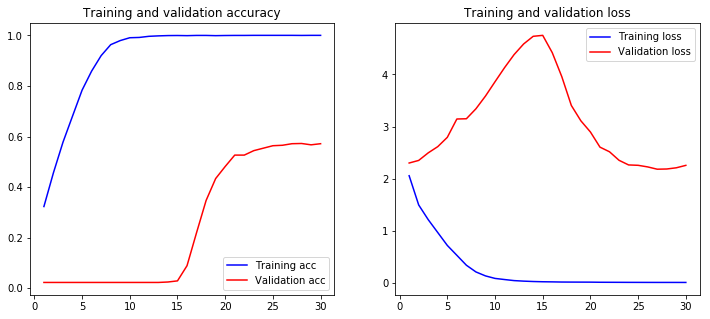

In [58]:
plot_history(history)